# Install and Import Necessary Libraries

In the exploration of potential NLP project ideas, I have previously conducted projects in classification and sentiment analysis. Seeking a shift to a different category, I opted to undertake a text summarization project with a focus on news articles.

In the contemporary digital landscape, the internet swiftly disseminates vast volumes of information worldwide within seconds. Traditional media outlets, including newspapers, have adapted by establishing online platforms to provide diverse information to their audience. Millions of news articles are delivered in a digital form and available for all the audience around the world. Nevertheless, the challenge arises when lengthy text articles struggle to convey valuable information efficiently to readers. Recognizing the need to expedite the consumption of news, the implementation of a text summarization engine emerges as a valuable solution.

In this project, I used the dataset I obtained from Kaggle which contains CNN articles, according categories, and actual summaries. Considering about the availability of GPUs and the size of the dataset, I decided to only use “Sports” news to train a model specifically targeting to summarize sports news. I used BART (Bidirectional and Auto-Regressive Transformers) as my pretrained base model and tried to apply additional training for sports news.


In [1]:
!pip install tensorflow
!pip install rouge_score
!pip install evaluate
!pip install torch
!pip install transformers
!pip install datasets
!pip install tqdm
!pip install rouge_score

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset, DataLoader
from transformers import BartTokenizer, BartForConditionalGeneration, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd
from rouge_score import rouge_scorer
from torch.cuda.amp import autocast, GradScaler
import string
from torch.nn.utils import clip_grad_norm_

#### Config GPU

In [3]:
tf.config.list_physical_devices('GPU')

[]

In [4]:
tf.config.list_physical_devices('GPU')

tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

# Loading Dataset

In [5]:
df = pd.read_csv("merge_df2.csv")

In [6]:
df

,Unnamed: 0,File_path,Articles,Summaries
0,0,politics,Budget to set scene for election..Gordon Brown...,- Increase in the stamp duty threshold from £6...
1,1,politics,Army chiefs in regiments decision..Military ch...,"""They are very much not for the good and will ..."
2,2,politics,Howard denies split over ID cards..Michael How...,Michael Howard has denied his shadow cabinet w...
3,3,politics,Observers to monitor UK election..Ministers wi...,The report said individual registration should...
4,4,politics,Kilroy names election seat target..Ex-chat sho...,"UKIP's leader, Roger Knapman, has said he is g..."
...,...,...,...,...
5444,5444,accidents,HONG KONG — Hundreds of pilot whales that s...,more than 500 rescuers tried frantically to se...
5445,5445,sports,"NICE, France — Rivère accepts the complim...",Signing balotelli was not just a way to garner...
5446,5446,business,FRANKFURT — Germans who never really warmed...,Although there was no evidence of that the bun...
5447,5447,sports,Charles Oakley has strong feelings about compe...,He questioned why any n. b. a. free agent woul...


#### Show the sum of missing values of features in the dataset

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5449 entries, 0 to 5448
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5449 non-null   int64 
 1   File_path   5449 non-null   object
 2   Articles    5449 non-null   object
 3   Summaries   5449 non-null   object
dtypes: int64(1), object(3)
memory usage: 170.4+ KB


In [8]:
df.shape

(5449, 4)

In [9]:
df['File_path'].unique()

array(['politics', 'sport', 'tech', 'entertainment', 'business', 'crime',
       'technology', 'art', 'science', 'health', 'architecture',
       'lifestyle', 'sports', 'law', 'accidents', 'environment '],
      dtype=object)

#### Rename some categories and show data distribution

In [10]:
# Define a dictionary to map old values to new values
value_mapping = {'sport': 'sports', 'tech': 'technology'}

# Replace values in the DataFrame using the replace method
df = df.replace(value_mapping)

In [11]:
df['File_path'].unique()

array(['politics', 'sports', 'technology', 'entertainment', 'business',
       'crime', 'art', 'science', 'health', 'architecture', 'lifestyle',
       'law', 'accidents', 'environment '], dtype=object)

In [12]:
df

,Unnamed: 0,File_path,Articles,Summaries
0,0,politics,Budget to set scene for election..Gordon Brown...,- Increase in the stamp duty threshold from £6...
1,1,politics,Army chiefs in regiments decision..Military ch...,"""They are very much not for the good and will ..."
2,2,politics,Howard denies split over ID cards..Michael How...,Michael Howard has denied his shadow cabinet w...
3,3,politics,Observers to monitor UK election..Ministers wi...,The report said individual registration should...
4,4,politics,Kilroy names election seat target..Ex-chat sho...,"UKIP's leader, Roger Knapman, has said he is g..."
...,...,...,...,...
5444,5444,accidents,HONG KONG — Hundreds of pilot whales that s...,more than 500 rescuers tried frantically to se...
5445,5445,sports,"NICE, France — Rivère accepts the complim...",Signing balotelli was not just a way to garner...
5446,5446,business,FRANKFURT — Germans who never really warmed...,Although there was no evidence of that the bun...
5447,5447,sports,Charles Oakley has strong feelings about compe...,He questioned why any n. b. a. free agent woul...


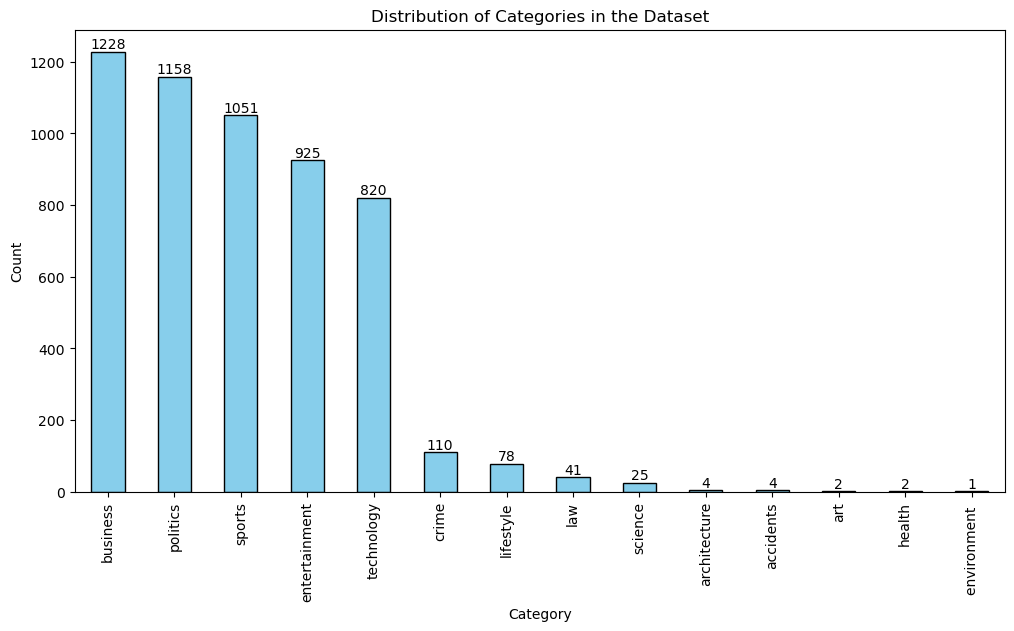

In [13]:
# Count the occurrences of each class
category_counts = df['File_path'].value_counts()

# Plot the result
plt.figure(figsize=(12, 6))
category_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Distribution of Categories in the Dataset')

# Display the count values on top of each bar
for i, count in enumerate(category_counts):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom')

plt.show()

### Cleaning Summerization Text

In [14]:
# function to make lower case
def to_lowercase(text):
    return text.str.lower()
#remove extra whitespaces and tabs
def remove_extra_whitespace_tabs(text):
    pattern = r'^\s+|\s+$'
    return text.str.replace(pattern, '')

# Function to remove special characters (keeping full stops)
def remove_special_characters(text):
    special_characters_pattern = r'[^a-zA-Z0-9\s]'
    text_without_special_chars = text.str.replace(special_characters_pattern, '')
    return text_without_special_chars

# Function to remove specific characters
def remove_specific_characters(text):
    # regular expression pattern for the characters to remove
    pattern = r'\.{2,}|[—!&$%^`\"_+=~:?;,\/-]+|\n|\t'
     
    # replace matches with an empty string
    cleaned_text = text.apply(lambda x: re.sub(pattern, ' ', x))
    
    # Remove extra white spaces
    cleaned_text = cleaned_text.apply(lambda x: ' '.join(x.split()))
    return cleaned_text

In [15]:
df['Articles'] = to_lowercase(df['Articles'])
df['Articles']

0       budget to set scene for election..gordon brown...
1       army chiefs in regiments decision..military ch...
2       howard denies split over id cards..michael how...
3       observers to monitor uk election..ministers wi...
4       kilroy names election seat target..ex-chat sho...
                              ...                        
5444    hong kong  —   hundreds of pilot whales that s...
5445    nice, france  —     rivère accepts the complim...
5446    frankfurt  —   germans who never really warmed...
5447    charles oakley has strong feelings about compe...
5448    hans rosling, a swedish doctor who transformed...
Name: Articles, Length: 5449, dtype: object

In [16]:
# remove extra white space and tabs
df['Articles'] = remove_extra_whitespace_tabs(df['Articles'])
df['Articles']

0       budget to set scene for election..gordon brown...
1       army chiefs in regiments decision..military ch...
2       howard denies split over id cards..michael how...
3       observers to monitor uk election..ministers wi...
4       kilroy names election seat target..ex-chat sho...
                              ...                        
5444    hong kong  —   hundreds of pilot whales that s...
5445    nice, france  —     rivère accepts the complim...
5446    frankfurt  —   germans who never really warmed...
5447    charles oakley has strong feelings about compe...
5448    hans rosling, a swedish doctor who transformed...
Name: Articles, Length: 5449, dtype: object

In [17]:
# remove special characters
df['Articles'] = remove_special_characters(df['Articles'])
df['Articles']

0       budget to set scene for election..gordon brown...
1       army chiefs in regiments decision..military ch...
2       howard denies split over id cards..michael how...
3       observers to monitor uk election..ministers wi...
4       kilroy names election seat target..ex-chat sho...
                              ...                        
5444    hong kong  —   hundreds of pilot whales that s...
5445    nice, france  —     rivère accepts the complim...
5446    frankfurt  —   germans who never really warmed...
5447    charles oakley has strong feelings about compe...
5448    hans rosling, a swedish doctor who transformed...
Name: Articles, Length: 5449, dtype: object

In [18]:
df['Articles'] = remove_specific_characters(df['Articles'])
df['Articles']

0       budget to set scene for election gordon brown ...
1       army chiefs in regiments decision military chi...
2       howard denies split over id cards michael howa...
3       observers to monitor uk election ministers wil...
4       kilroy names election seat target ex chat show...
                              ...                        
5444    hong kong hundreds of pilot whales that swam i...
5445    nice france rivère accepts the compliment but ...
5446    frankfurt germans who never really warmed up t...
5447    charles oakley has strong feelings about compe...
5448    hans rosling a swedish doctor who transformed ...
Name: Articles, Length: 5449, dtype: object

In [19]:
#### Filter categories and work on sports only

In [20]:
filtered_df = df[df['File_path'].isin(['sports'])]

In [21]:
filtered_df

,Unnamed: 0,File_path,Articles,Summaries
417,417,sports,hodges announces rugby retirement scarlets and...,"The 36-year-old, who has 54 caps, was Llanelli..."
418,418,sports,bomb threat at bernabeu stadium spectators wer...,Spectators were evacuated from Real Madrid's B...
419,419,sports,parmar ruled out of davis cup tie a knee injur...,The unheralded Sherwood was the surprise inclu...
420,420,sports,benitez issues warning to gerrard liverpool ma...,"Benitez responded: ""I spoke to Steven and said..."
421,421,sports,officials respond in court row australian tenn...,"Hewitt said he had had a ""gutful"" of trying to..."
...,...,...,...,...
5404,5404,sports,many of the world’s winter athletes now prepar...,as olympic officials review the evidence deliv...
5411,5411,sports,the sale of a major league sports team always ...,would fans or sponsors boycott or embrace the ...
5436,5436,sports,welcome to our picks a guide to the best stuff...,enjoy them for the first time when you have so...
5445,5445,sports,nice france rivère accepts the compliment but ...,Signing balotelli was not just a way to garner...


In [22]:
def remove_emojis_and_symbols(text):
    # Remove emojis
    text = re.sub(r'[\U00010000-\U0010ffff]', '', text)
    # Remove non-alphanumeric symbols
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

In [23]:
filtered_df['Articles'] = filtered_df['Articles'].apply(remove_emojis_and_symbols)

C:\Users\61\AppData\Local\Temp\ipykernel_52048\2494307040.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Articles'] = filtered_df['Articles'].apply(remove_emojis_and_symbols)


In [24]:
filtered_df['Summaries'] = filtered_df['Summaries'].apply(remove_emojis_and_symbols)

C:\Users\61\AppData\Local\Temp\ipykernel_52048\969203157.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Summaries'] = filtered_df['Summaries'].apply(remove_emojis_and_symbols)


In [25]:
filtered_df

,Unnamed: 0,File_path,Articles,Summaries
417,417,sports,hodges announces rugby retirement scarlets and...,The 36yearold who has 54 caps was Llanellis pl...
418,418,sports,bomb threat at bernabeu stadium spectators wer...,Spectators were evacuated from Real Madrids Be...
419,419,sports,parmar ruled out of davis cup tie a knee injur...,The unheralded Sherwood was the surprise inclu...
420,420,sports,benitez issues warning to gerrard liverpool ma...,Benitez responded I spoke to Steven and said t...
421,421,sports,officials respond in court row australian tenn...,Hewitt said he had had a gutful of trying to p...
...,...,...,...,...
5404,5404,sports,many of the worlds winter athletes now prepari...,as olympic officials review the evidence deliv...
5411,5411,sports,the sale of a major league sports team always ...,would fans or sponsors boycott or embrace the ...
5436,5436,sports,welcome to our picks a guide to the best stuff...,enjoy them for the first time when you have so...
5445,5445,sports,nice france rivre accepts the compliment but r...,Signing balotelli was not just a way to garner...


C:\Users\61\AppData\Local\Temp\ipykernel_52048\2625111853.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Summary_Length'] = filtered_df['Summaries'].apply(lambda x: len(x.split()))


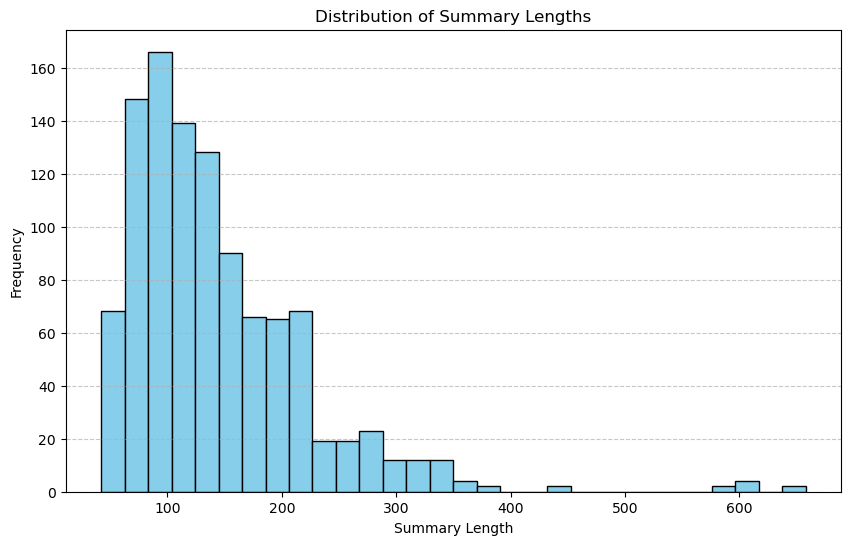

In [26]:
filtered_df['Summary_Length'] = filtered_df['Summaries'].apply(lambda x: len(x.split()))

# Plotting the distribution
plt.figure(figsize=(10, 6))
plt.hist(filtered_df['Summary_Length'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Summary Lengths')
plt.xlabel('Summary Length')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

In [27]:
#device to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Tokenize and preprocess the text data
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')
max_length = 1024  # Maximum sequence length

In [28]:
def tokenize_text(text):
    inputs = tokenizer.encode(text, return_tensors="pt", max_length=382, truncation=True, padding='max_length', return_attention_mask=True)
    return inputs.to(device)  # Move the tokenized inputs to the GPU

def tokenize_summary(text):
    inputs = tokenizer.encode(text, return_tensors="pt", max_length=155, truncation=True, padding='max_length', return_attention_mask=True)
    return inputs.to(device)  # Move the tokenized summaries to the GPU


filtered_df['TokenizedText'] = filtered_df['Articles'].apply(tokenize_text)
filtered_df['TokenizedSummary'] = filtered_df['Summaries'].apply(tokenize_summary)

C:\Users\61\AppData\Local\Temp\ipykernel_52048\3657970675.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['TokenizedText'] = filtered_df['Articles'].apply(tokenize_text)
C:\Users\61\AppData\Local\Temp\ipykernel_52048\3657970675.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['TokenizedSummary'] = filtered_df['Summaries'].apply(tokenize_summary)


In [29]:
train_df, test_df = train_test_split(filtered_df, test_size=0.2, random_state=42)

In [30]:
X_train = torch.stack([seq.squeeze() for seq in train_df['TokenizedText']])
Y_train = torch.stack([seq.squeeze() for seq in train_df['TokenizedSummary']])
X_test = torch.stack([seq.squeeze() for seq in test_df['TokenizedText']])
Y_test = torch.stack([seq.squeeze() for seq in test_df['TokenizedSummary']])

In [31]:
train_dataset = TensorDataset(X_train, Y_train)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataset = TensorDataset(X_test, Y_test)
test_dataloader = DataLoader(test_dataset, batch_size=4)

In [32]:
model = BartForConditionalGeneration.from_pretrained('facebook/bart-base')

In [33]:
# Create a GradScaler for mixed-precision training
scaler = GradScaler()

C:\Users\61\anaconda3\Lib\site-packages\torch\cuda\amp\grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [34]:
# Define hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move the model to the GPU
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=50, num_training_steps=len(train_dataloader) * 10)  # Add learning rate scheduler
early_stopping_rounds = 2
best_rouge_score = -1
current_round = 0



C:\Users\61\anaconda3\Lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [35]:
# Define gradient accumulation steps
accumulation_steps = 20  # You can adjust this number

def train(model, dataloader, optimizer, scheduler):
    model.train()
    total_loss = 0.0
    optimizer.zero_grad()

    for step, batch in enumerate(tqdm(dataloader, desc="Training")):
        inputs = batch[0].to(device)  # Move the input batch to the GPU
        attention_mask = (inputs != 0).float().to(device)  # Create attention mask
        targets = batch[1].to(device)  # Move the target batch to the GPU

        with autocast():
            outputs = model(input_ids=inputs, attention_mask=attention_mask, decoder_input_ids=targets, labels=targets)
            loss = outputs.loss

        # Perform gradient accumulation
        loss = loss / accumulation_steps
        scaler.scale(loss).backward()

        if (step + 1) % accumulation_steps == 0:
            # Update gradients and optimizer once every accumulation_steps
            clip_grad_norm_(model.parameters(), max_norm=1.0)  # Optional gradient clipping
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        total_loss += loss.item()

    return total_loss / len(dataloader)



In [36]:
for epoch in range(3):
    train_loss = train(model, train_dataloader, optimizer, scheduler)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}")

Training:   0%|          | 0/210 [00:00<?, ?it/s]C:\Users\61\anaconda3\Lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Training: 100%|██████████| 210/210 [06:28<00:00,  1.85s/it]


Epoch 1, Train Loss: 0.5705


Training: 100%|██████████| 210/210 [06:29<00:00,  1.86s/it]


Epoch 2, Train Loss: 0.5687


Training: 100%|██████████| 210/210 [06:28<00:00,  1.85s/it]

Epoch 3, Train Loss: 0.5706


In [37]:
def evaluate1(model, dataloader):
    model.eval()

    test_articles = []
    actual_summaries = []
    predicted_summaries = []
    rouge1_precision_scores = []

    scorer = rouge_scorer.RougeScorer(['rouge1'])

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating Test"):
            inputs = batch[0].to(device)
            attention_mask = (inputs != 0).float().to(device)
            targets = batch[1].to(device)
            outputs = model.generate(input_ids=inputs, attention_mask=attention_mask, max_length=155, num_beams=30, length_penalty=2.0, early_stopping=True)

            for output, target, input_text in zip(outputs, targets, inputs):
                # Calculate ROUGE-1 precision for each sample
                output_text = tokenizer.decode(output, skip_special_tokens=True)
                target_text = tokenizer.decode(target, skip_special_tokens=True)
                rouge_scores = scorer.score(output_text, target_text)
                rouge1_precision_scores.append(rouge_scores['rouge1'].precision)

                # Append tokenized text, actual summaries, and predicted summaries
                test_articles.append(tokenizer.decode(input_text, skip_special_tokens=True))
                actual_summaries.append(target_text)
                predicted_summaries.append(output_text)

    return test_articles, actual_summaries, predicted_summaries, rouge1_precision_scores

In [38]:
def evaluate2(model, dataloader):
    model.eval()

    test_articles = []
    actual_summaries = []
    predicted_summaries = []
    rouge2_precision_scores = []

    scorer = rouge_scorer.RougeScorer(['rouge2'])

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating Test"):
            inputs = batch[0].to(device)
            attention_mask = (inputs != 0).float().to(device)
            targets = batch[1].to(device)
            outputs = model.generate(input_ids=inputs, attention_mask=attention_mask, max_length=512, num_beams=30, length_penalty=3.0, early_stopping=True)

            for output, target, input_text in zip(outputs, targets, inputs):
                # Calculate ROUGE-2 precision for each sample
                output_text = tokenizer.decode(output, skip_special_tokens=True)
                target_text = tokenizer.decode(target, skip_special_tokens=True)
                rouge_scores = scorer.score(output_text, target_text)
                rouge2_precision_scores.append(rouge_scores['rouge2'].precision)

                # Append tokenized text, actual summaries, and predicted summaries
                test_articles.append(tokenizer.decode(input_text, skip_special_tokens=True))
                actual_summaries.append(target_text)
                predicted_summaries.append(output_text)

    return test_articles, actual_summaries, predicted_summaries, rouge2_precision_scores

In [39]:
# Evaluate the model
test_articles, actual_summaries, predicted_summaries, rouge1_precision_scores = evaluate1(model, test_dataloader)

# Create a dictionary with the extracted data
data = {
    'Article': test_articles,
    'Actual Summary': actual_summaries,
    'Predicted Summary': predicted_summaries,
    'ROUGE-1 Precision': rouge1_precision_scores,
}

# Create a Pandas DataFrame from the dictionary
results_rouge1_df = pd.DataFrame(data)


# Display the DataFrame
pd.set_option('display.max_colwidth', None)
results_rouge1_df.head(5)

Evaluating Test: 100%|██████████| 53/53 [49:01<00:00, 55.50s/it]


,Article,Actual Summary,Predicted Summary,ROUGE-1 Precision
0,van nistelrooy set to return manchester united striker ruud van nistelrooy may make his comeback after an achilles tendon injury in the fa cup fifth round tie at everton on saturday he has been out of action for nearly three months and had targeted a return in the champions league tie with ac milan on 23 february but manchester united manager sir alex ferguson hinted he may be back early he said there is a chance he could be involved at everton but well just have to see how he comes through training the 28 year old has been training in holland and ferguson said ruud comes back on tuesday and we need to assess how far on he is the training he has been doing in holland has been perfect and i am very satisfied with it even without van nistelrooy united made it 13 wins in 15 league games with a 2 0 derby victory at manchester city on sunday but they will be boosted by the return of the dutch international who is the clubs top scorer this season with 12 goals he has not played since aggravating the injury in the 3 0 win against west brom on 27 november ferguson was unhappy with van nistelrooy for not revealing he was carrying an injury united have also been hit by injuries to both alan smith and louis saha during van nistelrooys absence meaning wayne rooney has sometimes had to play in a lone role up front the teenager has responded with six goals in nine games including the first goal against city on sunday,The 28yearold has been training in Holland and Ferguson said Ruud comes back on Tuesday and we need to assess how far on he isThe training he has been doing in Holland has been perfect and I am very satisfied with itManchester United striker Ruud van Nistelrooy may make his comeback after an Achilles tendon injury in the FA Cup fifth round tie at Everton on SaturdayEven without Van Nistelrooy United made it 13 wins in 15 league games with a 20 derby victory at Manchester City on SundayUnited have also been hit by injuries to both Alan Smith and Louis Saha during Van Nistelrooys absence meaning Wayne Rooney has sometimes had to play in a lone role up front,"van nistelrooy set to return manchester united striker ruud van nistelirooy may make his comeback after an achilles tendon injury in the fa cup fifth round tie at everton on saturday he has been out of action for nearly three months and had targeted a return in the champions league tie with ac milan on 23 february but Manchester united manager sir alex ferguson hinted he may be back early he said there is a chance he could be involved at ever, everton but well just have to see how he comes through training the 28 year old has been training in holland and ferguson said ruud comes back on tuesday and we need to assess how far on he is the training he has",0.558333
1,brentford v southampton griffin park tuesday 1 march 1945 gmt barry knight kent home to manchester united in the quarter finals midfielder andrew frampton and striker deon burton are both slight doubts with hamstring injuries but should be fit saints are missing their entire first choice midfield of jamie redknapp graeme le saux nigel quashie and david prutton anders svensson and matt oakley are likely replacements with kevin phillips also scheduled to start with henri camara rested brentford boss martin allen after conceding eight goals in our last three matches i have to admit im not very confident theres no doubt were the underdogs and after defending so poorly recently its not looking good southampton have just drawn with the premiership champions and that makes our task harder than it was already southampton boss harry redknapp we know they can give us problems brentford have done well but we are the premiership side and should have the better players staying in the premiership is our priority we want to win of course we do well battle but if it comes to a football match i think well win key match stats brentford are the lowest ranked club left in th

In [40]:
results_rouge1_df.to_excel('results_rouge1.xlsx')

In [41]:
# Evaluate the model
test_articles, actual_summaries, predicted_summaries, rouge2_precision_scores = evaluate2(model, test_dataloader)

# Create a dictionary with the extracted data
data = {
    'Article': test_articles,
    'Actual Summary': actual_summaries,
    'Predicted Summary': predicted_summaries,
    'ROUGE-2 Precision': rouge2_precision_scores,
}

# Create a Pandas DataFrame from the dictionary
results_rouge2_df = pd.DataFrame(data)

results_rouge2_df.head(5)

Evaluating Test: 100%|██████████| 53/53 [4:10:44<00:00, 283.86s/it]  


,Article,Actual Summary,Predicted Summary,ROUGE-2 Precision
0,van nistelrooy set to return manchester united striker ruud van nistelrooy may make his comeback after an achilles tendon injury in the fa cup fifth round tie at everton on saturday he has been out of action for nearly three months and had targeted a return in the champions league tie with ac milan on 23 february but manchester united manager sir alex ferguson hinted he may be back early he said there is a chance he could be involved at everton but well just have to see how he comes through training the 28 year old has been training in holland and ferguson said ruud comes back on tuesday and we need to assess how far on he is the training he has been doing in holland has been perfect and i am very satisfied with it even without van nistelrooy united made it 13 wins in 15 league games with a 2 0 derby victory at manchester city on sunday but they will be boosted by the return of the dutch international who is the clubs top scorer this season with 12 goals he has not played since aggravating the injury in the 3 0 win against west brom on 27 november ferguson was unhappy with van nistelrooy for not revealing he was carrying an injury united have also been hit by injuries to both alan smith and louis saha during van nistelrooys absence meaning wayne rooney has sometimes had to play in a lone role up front the teenager has responded with six goals in nine games including the first goal against city on sunday,The 28yearold has been training in Holland and Ferguson said Ruud comes back on Tuesday and we need to assess how far on he isThe training he has been doing in Holland has been perfect and I am very satisfied with itManchester United striker Ruud van Nistelrooy may make his comeback after an Achilles tendon injury in the FA Cup fifth round tie at Everton on SaturdayEven without Van Nistelrooy United made it 13 wins in 15 league games with a 20 derby victory at Manchester City on SundayUnited have also been hit by injuries to both Alan Smith and Louis Saha during Van Nistelrooys absence meaning Wayne Rooney has sometimes had to play in a lone role up front,van nistelrooy set to return manchester united striker ruud van nistelirooy may make his comeback after an achilles tendon injury in the fa cup fifth round tie at everton on saturday he has been out of action for nearly three months and had targeted a return in the champions league tie with ac milan on 23 february but Manchester united manager sir alex ferguson hinted he may be back early he said there is a chance he could be involved at everdayton but well just have to see how he comes through training the 28 year old has been training in holland and ferguson said ruud comes back on tuesday and we need to assess how far on he is the training he have been doing in Holland has been perfect and i am very satisfied with it even without van NistelROoy united made it 13 wins in 15 league games with a 2 0 derby victory at manchester city on sunday but they will be boosted by the return of the dutch international who is the clubs top scorer this season with 12 goals he has not played since aggravating the injury in his the 3 0 win against west brom on 27 november ferguson was unhappy with van nisteelroooy for not revealing he was carrying an injury united have also been hit by injuries to both alan smith and louis saha during van nisselrooys absence meaning wayne rooney has sometimes had to play in a lone role up front the teenager has responded with six goals in nine games including the only goal he had not played for long time on he was wearing his training he was only training in the league on urok ufcfc player of the year after ufc ufc defender ufc player ufficffic player su su suffice defender defender kapapitated by injury umpirokapo player Mau Maucapoapoapo defender on kimbede Maucane on kimonthly he is wearing a long time training he is playing in his current role as well as his current playing role in the 24th wee

In [42]:
results_rouge2_df.to_excel('results_rouge2.xlsx')

In [43]:

model.save_pretrained("pre_train_sum_batch_4")

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


In [44]:
abc="Samantha Bee called out Mark Meadows, who was White House chief of staff under Donald Trump, after 2,319 of his text messages revealed how deep he and other key Republicans were involved in the plot to overturn the election and stop Joe Biden from becoming president. ??More than 2,000 text messages!?? Bee said on ??Full Frontal?? on Thursday night. ??This proves definitively that Mark Meadows is a gossipy little bitch.?? The messages included Fox News host Sean Hannity taking orders from the White House on how to help with voter turnout on Election Day, Sen. Mike Lee (R-Utah) pleading for talking points after the election and Rep. Marjorie Taylor Greene (R-Ga.) calling for ??Marshall?? law. ??Marshall??s Law, as everyone knows, is that no one should pay retail prices for quality yoga pants,?? Bee cracked. Bee also noted that Meadows still has more than 1,000 messages that he hasn??t turned over. ??Damn! Mark Meadows, you are messy,?? she said. ??Delete my number!??Bee urged the Jan. 6 committee to push forward with its investigation. ??If there??s one thing these texts prove it??s that it doesn??t matter to Republicans if they know for a fact that Joe Biden won the election,?? she said. ??What matters is these human bumper stickers are more than willing to use lies and a violent base to both take and keep power.?? And she warned that if they??re not held accountable, it??ll happen again:"

In [45]:
input_ids = tokenizer.encode(abc, return_tensors="pt")

In [46]:
summary_ids = model.generate(input_ids=input_ids, max_length=1024, num_beams=17, length_penalty=2.0, early_stopping=False)
generated_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)


In [47]:
generated_summary

'Samantha Bee called out Mark Meadows, who was White House chief of staff under Donald Trump, after 2,319 of his text messages revealed how deep he and other key Republicans were involved in the plot to overturn the election and stop Joe Biden from becoming president.?\x80?More than 2,000 text messages!?\x80” Bee said on?\x83?Full Frontal?\x80& on Thursday night.?\u2000?This proves definitively that Mark Meadows is a gossipy little bitch.?\x80?, Bee said. The messages included Fox News host Sean Hannity taking orders from the White House on how to help with voter turnout on Election Day, Sen. Mike Lee (R-Utah) pleading for talking points after the election, Rep. Marjorie Taylor, a member of the House Judiciary Committee, and Rep. David Cicilline, R-N.Y., calling for an investigation into Meadows’ alleged role in the conspiracy, according to Bee’s transcript of the Jan. 6 committee hearing, as well as a letter from Rep. Mark Meadows to Rep. Bob Goodlatte, D-Va., urging him to “delete my

In [52]:
def clean_text(text):
    # Remove punctuation and convert to lowercase
    translator = str.maketrans("", "", string.punctuation)
    cleaned_text = text.translate(translator).lower()
    return cleaned_text

In [53]:
def rouge_1_evaluation(reference, generated):
    reference = clean_text(reference)
    generated = clean_text(generated)

    reference_tokens = reference.split()
    generated_tokens = generated.split()

    # Calculate ROUGE-1 recall
    overlapping_tokens = set(reference_tokens) & set(generated_tokens)
    recall = len(overlapping_tokens) / len(reference_tokens) if len(reference_tokens) > 0 else 0.0

    return recall

In [54]:
rouge_1_recall = rouge_1_evaluation(abc, generated_summary)
print(f"ROUGE-1 Recall: {rouge_1_recall}")

ROUGE-1 Recall: 0.6059322033898306


In [55]:
def rouge_2_evaluation(reference, generated):
    reference = clean_text(reference)
    generated = clean_text(generated)

    reference_bigrams = list(zip(reference.split()[:-1], reference.split()[1:]))
    generated_bigrams = list(zip(generated.split()[:-1], generated.split()[1:]))

    # Calculate ROUGE-2 recall
    overlapping_bigrams = set(reference_bigrams) & set(generated_bigrams)
    recall = len(overlapping_bigrams) / len(reference_bigrams) if len(reference_bigrams) > 0 else 0.0

    return recall

In [56]:
rouge_2_recall = rouge_2_evaluation(abc, generated_summary)
print(f"ROUGE-2 Recall: {rouge_2_recall}")

ROUGE-2 Recall: 0.7489361702127659


In [ ]:
model.evaluate()